 Spam Email Detection

1. Load and Prepare Spam Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import urllib.request
import os

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Download the SMS Spam Collection dataset
print("Downloading SMS Spam Collection dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
file_name = "spam.zip"

if not os.path.exists("SMSSpamCollection"):
    urllib.request.urlretrieve(url, file_name)
    import zipfile
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(".")
    os.remove(file_name)

# Load the dataset
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 messages:")
print(df.head())

# Check class distribution
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nPercentage of spam: {(df['label'] == 'spam').mean():.2%}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Dataset shape: (5572, 2)

First 5 messages:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Percentage of spam: 13.41%


2: Preprocess Text Data

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and apply stemming
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word.isalpha()]

    return ' '.join(tokens)

# Download missing NLTK resource
nltk.download('punkt_tab')

# Apply preprocessing
print("Preprocessing messages...")
df['processed_message'] = df['message'].apply(preprocess_text)

# Convert labels to binary
df['label_binary'] = df['label'].map({'ham': 0, 'spam': 1})

print("\nOriginal vs Processed:")
for i in range(3):
    print(f"\nOriginal ({df.loc[i, 'label']}): {df.loc[i, 'message'][:80]}...")
    print(f"Processed: {df.loc[i, 'processed_message'][:80]}...")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Preprocessing messages...

Original vs Processed:

Original (ham): Go until jurong point, crazy.. Available only in bugis n great world la e buffet...
Processed: go jurong point crazi avail bugi n great world la e buffet cine got amor wat...

Original (ham): Ok lar... Joking wif u oni......
Processed: ok lar joke wif u oni...

Original (spam): Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 8...
Processed: free entri wkli comp win fa cup final tkt may text fa receiv entri questionstd t...


3: Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Split data
X = df['processed_message']
y = df['label_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Create TF-IDF features
print("\nCreating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Create Bag-of-Words features
print("\nCreating Bag-of-Words features...")
bow_vectorizer = CountVectorizer(max_features=3000, ngram_range=(1, 2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"BoW feature matrix shape: {X_train_bow.shape}")

# Show most common words in spam vs ham
ham_words = ' '.join(df[df['label'] == 'ham']['processed_message'])
spam_words = ' '.join(df[df['label'] == 'spam']['processed_message'])

from collections import Counter
ham_word_freq = Counter(ham_words.split()).most_common(10)
spam_word_freq = Counter(spam_words.split()).most_common(10)

print("\nTop 10 words in Ham messages:")
for word, freq in ham_word_freq:
    print(f"  {word}: {freq}")

print("\nTop 10 words in Spam messages:")
for word, freq in spam_word_freq:
    print(f"  {word}: {freq}")

Training set size: 3900
Test set size: 1672

Creating TF-IDF features...
TF-IDF feature matrix shape: (3900, 3000)

Creating Bag-of-Words features...
BoW feature matrix shape: (3900, 3000)

Top 10 words in Ham messages:
  u: 985
  im: 452
  go: 417
  get: 360
  come: 295
  call: 289
  ltgt: 276
  ok: 273
  dont: 265
  ur: 246

Top 10 words in Spam messages:
  call: 366
  free: 216
  txt: 163
  u: 148
  ur: 144
  text: 138
  mobil: 135
  claim: 115
  stop: 115
  repli: 109


4: Implement Naive Bayes Classifier

Training Naive Bayes classifier...

Naive Bayes Results (TF-IDF features):
Accuracy: 0.9737
ROC-AUC: 0.9771

Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1448
        spam       0.99      0.81      0.89       224

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.94      1672
weighted avg       0.97      0.97      0.97      1672


Naive Bayes Results (BoW features):
Accuracy: 0.9749


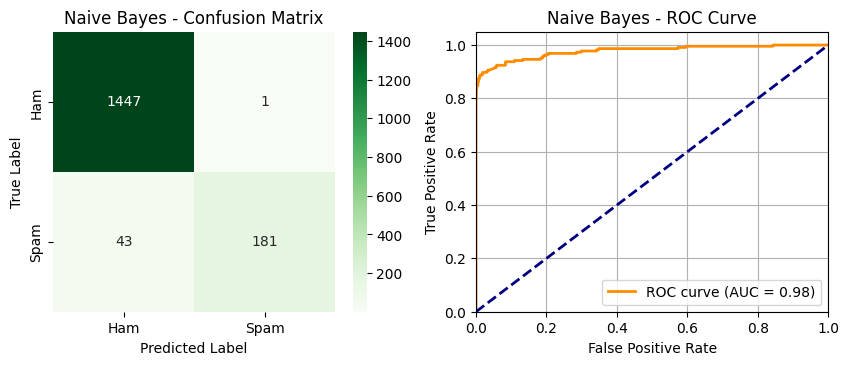

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

print("Training Naive Bayes classifier...")

# Train with TF-IDF features
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(X_train_tfidf, y_train)

# Train with BoW features
nb_model_bow = MultinomialNB()
nb_model_bow.fit(X_train_bow, y_train)

# Make predictions
y_pred_nb_tfidf = nb_model_tfidf.predict(X_test_tfidf)
y_pred_nb_bow = nb_model_bow.predict(X_test_bow)

# Get probabilities for ROC curve
y_pred_proba_nb = nb_model_tfidf.predict_proba(X_test_tfidf)[:, 1]

print("\nNaive Bayes Results (TF-IDF features):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb_tfidf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_nb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb_tfidf, target_names=['ham', 'spam']))

print("\nNaive Bayes Results (BoW features):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb_bow):.4f}")

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb_tfidf)
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('Naive Bayes - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_nb)
plt.subplot(2, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_nb):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

5: Implement SVM Classifier

Training SVM classifier...
SVM training time: 1.09 seconds

SVM Results:
Accuracy: 0.9809
ROC-AUC: 0.9818

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       0.98      0.88      0.92       224

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



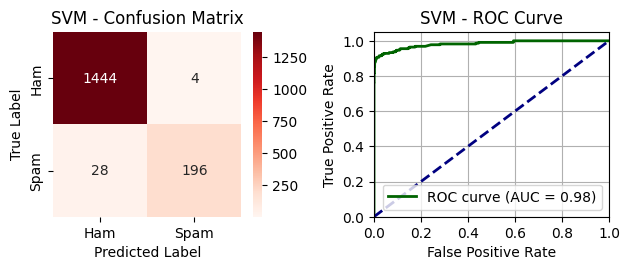

In [ ]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import time

print("Training SVM classifier...")

# Note: We'll use a subset for faster training
sample_size = 2000
if X_train_tfidf.shape[0] > sample_size:
    X_train_svm = X_train_tfidf[:sample_size]
    y_train_svm = y_train[:sample_size]
else:
    X_train_svm = X_train_tfidf
    y_train_svm = y_train

# Train SVM (using linear kernel for efficiency)
start_time = time.time()
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_svm, y_train_svm)
training_time = time.time() - start_time

print(f"SVM training time: {training_time:.2f} seconds")

# Make predictions
y_pred_svm = svm_model.predict(X_test_tfidf)
y_pred_proba_svm = svm_model.predict_proba(X_test_tfidf)[:, 1]

print("\nSVM Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['ham', 'spam']))

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.subplot(2, 2, 3)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('SVM - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_proba_svm)
plt.subplot(2, 2, 4)
plt.plot(fpr_svm, tpr_svm, color='darkgreen', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_svm):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

6: Compare Models and Test with Examples

In [ ]:
print("="*60)
print("MODEL COMPARISON: Naive Bayes vs SVM")
print("="*60)

# Compare metrics
models = ['Naive Bayes (TF-IDF)', 'Naive Bayes (BoW)', 'SVM (Linear)']
accuracies = [
    accuracy_score(y_test, y_pred_nb_tfidf),
    accuracy_score(y_test, y_pred_nb_bow),
    accuracy_score(y_test, y_pred_svm)
]
auc_scores = [
    roc_auc_score(y_test, y_pred_proba_nb),
    roc_auc_score(y_test, nb_model_bow.predict_proba(X_test_bow)[:, 1]),
    roc_auc_score(y_test, y_pred_proba_svm)
]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': [f"{acc:.4f}" for acc in accuracies],
    'ROC-AUC': [f"{auc:.4f}" for auc in auc_scores],
    'Training Time': ['Fast', 'Fast', 'Medium']
})

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Test with custom examples
test_emails = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize now!",
    "Hi John, just checking if you're still meeting for lunch tomorrow at 12?",
    "URGENT: Your bank account has been compromised. Verify your details immediately at: secure-bank-login.com",
    "Meeting reminder: Project review at 3 PM in conference room B. Please bring your reports.",
    "You are selected for a free iPhone 15! Call now to claim: 1-800-PRIZE-NOW"
]

print("\n" + "="*60)
print("TESTING WITH SAMPLE EMAILS")
print("="*60)

def predict_email(text, model, vectorizer, model_name):
    processed = preprocess_text(text)
    features = vectorizer.transform([processed])

    if model_name == 'svm':
        prediction = model.predict(features)[0]
        proba = model.predict_proba(features)[0]
    else:
        prediction = model.predict(features)[0]
        proba = model.predict_proba(features)[0]

    label = 'SPAM' if prediction == 1 else 'HAM'
    confidence = proba[1] if prediction == 1 else proba[0]

    return label, confidence

for i, email in enumerate(test_emails):
    print(f"\nEmail {i+1}: {email[:60]}...")

    nb_label, nb_conf = predict_email(email, nb_model_tfidf, tfidf_vectorizer, 'nb')
    svm_label, svm_conf = predict_email(email, svm_model, tfidf_vectorizer, 'svm')

    print(f"  Naive Bayes: {nb_label} (confidence: {nb_conf:.2%})")
    print(f"  SVM: {svm_label} (confidence: {svm_conf:.2%})")

# Feature importance analysis
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get most important features for Naive Bayes
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
log_prob = nb_model_tfidf.feature_log_prob_

# Features that indicate spam (high probability in spam class)
spam_features_idx = np.argsort(log_prob[1] - log_prob[0])[-10:]
spam_features = feature_names[spam_features_idx]

# Features that indicate ham (high probability in ham class)
ham_features_idx = np.argsort(log_prob[0] - log_prob[1])[-10:]
ham_features = feature_names[ham_features_idx]

print("\nTop 10 features indicating SPAM:")
for feature in spam_features[::-1]:  # Reverse to show most important first
    print(f"  - {feature}")

print("\nTop 10 features indicating HAM:")
for feature in ham_features[::-1]:
    print(f"  - {feature}")

MODEL COMPARISON: Naive Bayes vs SVM

Model Performance Comparison:
               Model Accuracy ROC-AUC Training Time
Naive Bayes (TF-IDF)   0.9737  0.9771          Fast
   Naive Bayes (BoW)   0.9749  0.9695          Fast
        SVM (Linear)   0.9809  0.9818        Medium

TESTING WITH SAMPLE EMAILS

Email 1: Congratulations! You've won a $1000 Walmart gift card. Click...
  Naive Bayes: SPAM (confidence: 86.26%)
  SVM: SPAM (confidence: 98.66%)

Email 2: Hi John, just checking if you're still meeting for lunch tom...
  Naive Bayes: HAM (confidence: 99.34%)
  SVM: HAM (confidence: 99.91%)

Email 3: URGENT: Your bank account has been compromised. Verify your ...
  Naive Bayes: SPAM (confidence: 55.76%)
  SVM: HAM (confidence: 71.99%)

Email 4: Meeting reminder: Project review at 3 PM in conference room ...
  Naive Bayes: HAM (confidence: 96.77%)
  SVM: HAM (confidence: 95.00%)

Email 5: You are selected for a free iPhone 15! Call now to claim: 1-...
  Naive Bayes: SPAM (confidence: 94